In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import (RFE, SelectFpr, SelectKBest,
                                       f_regression)
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from tabulate import tabulate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [25]:
import warnings
warnings.filterwarnings("ignore")

### Helper functions

In [26]:
def print_df(df):
    print(tabulate(df, headers='keys', tablefmt='psql'))

### Parse the combined Ukraine data

In [27]:
file_path = "Ukraine_combined_full.xlsx"

In [28]:
df = pd.read_excel(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 47 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   Unnamed: 0                                                                                  400 non-null    int64  
 1   Unnamed: 1                                                                                  400 non-null    object 
 2   К-сть лікарень                                                                              400 non-null    int64  
 3   Флюорографічні огляди наседення (на 100 тис.)                                               400 non-null    object 
 4   Проведено вакцинацій                                                                        400 non-null    int64  
 5   Захворювання на активний туберкульоз легень

### Clean and process the dataframe

#### Add missing column names and rename ukrainian column names to english ones

In [29]:
new_column_names = {
    'Unnamed: 0': 'Рік',
    'Unnamed: 1': 'Область',
}
df = df.rename(columns=new_column_names)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 47 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   Рік                                                                                         400 non-null    int64  
 1   Область                                                                                     400 non-null    object 
 2   К-сть лікарень                                                                              400 non-null    int64  
 3   Флюорографічні огляди наседення (на 100 тис.)                                               400 non-null    object 
 4   Проведено вакцинацій                                                                        400 non-null    int64  
 5   Захворювання на активний туберкульоз легень

#### Make Regoin categorical

In [30]:
# region_mapping = dict(enumerate(df['Область'].unique()))

df['Область'] = pd.Categorical(df['Область'])
df['Область'] = df['Область'].cat.codes

df

,Рік,Область,К-сть лікарень,Флюорографічні огляди наседення (на 100 тис.),Проведено вакцинацій,Захворювання на активний туберкульоз легень серед усього населення України,Кількість хворих на активний туберкульоз органів дихання (включно з туберкульозом легенів),Бактеріовиділення,Захворюваність на позалегеневий туберкульоз серед усього населення України,Захворюваність 0-14 років,...,Р-тат л-вання рецедивів (вибув),МРТБ (кількість діагностованих),Р-тат л-вання МРТБ (вилікувано),Р-тат л-вання МРТБ (невдале л-вання),Р-тат л-вання МРТБ (перерване л-вання),Р-тат л-вання МРТБ (вибув),Хірургічне л-вання (легень к-сть операцій),Хірургічне л-вання (позал. к-сть операцій),Смертність на 100 тис.,Померлі діти до 14 років
0,2007,2,2,65.2,16421,55.0,57.6,28.2,4.7,5.9,...,1,248,10,3,9,5,26,30,12.743,2
1,2007,1,1,47.3,14620,57.9,64.4,30.3,9.9,5.2,...,0,79,0,0,0,0,95,121,25.403,0
2,2007,3,6,69.1,34346,84.7,89.6,33.0,9.1,12.6,...,8,573,59,8,29,10,95,10,30.705,1
3,2007,4,14,55.4,40865,87.2,92.0,33.9,7.0,12.9,...,9,437,105,25,26,6,186,300,32.314,1
4,2007,5,1,55.2,14130,72.5,79.7,33.2,10.4,9.0,...,0,109,3,0,2,0,18,20,14.417,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2022,20,1,31.7,6456,28.6,30.4,22.2,3.8,4.7,...,0,110,72,3,8,0,8,5,7.400,0
396,2022,21,1,29,6153,40.5,44.0,32.2,7.0,8.9,...,0,127,41,12,16,0,39,6,9.100,0
397,2022,22,1,29,6135,25.0,30.7,27.8,1.0,5.3,...,0,33,17,2,4,0,0,0,7.700,1
398,2022,23,1,27.8,3866,35.6,38.0,27.6,5.5,13.6,...,0,127,36,10,24,0,34,0,10.000,0


In [31]:

df_sorted = df.sort_values(by=['Область', 'Рік'])

df_sorted.replace('-', pd.NA, inplace=True)

numeric_columns = df_sorted.columns[2:]
df_sorted[numeric_columns] = df_sorted[numeric_columns].replace(',', '', regex=True).apply(pd.to_numeric)

grouped = df_sorted.groupby('Рік')

def fill_missing(group):
    group = group.copy()
    for col in numeric_columns:
        for idx, value in group[col].items():
            if pd.isna(value):
                prev_year = group.loc[:idx, col].dropna().iloc[-1] if idx > 0 else pd.NA
                next_year = group.loc[idx:, col].dropna().iloc[0] if idx < len(group) - 1 else pd.NA
                
                if pd.isna(prev_year) and pd.isna(next_year):
                    group.at[idx, col] = pd.NA
                elif pd.isna(prev_year):
                    group.at[idx, col] = next_year
                elif pd.isna(next_year):
                    group.at[idx, col] = prev_year
                else:
                    group.at[idx, col] = (prev_year + next_year) / 2
    return group

df_filled = grouped.apply(fill_missing)

df_filled.reset_index(drop=True, inplace=True)

print("Length of df_filled:", len(df_filled))

df = df_filled
df

Length of df_filled: 400


,Рік,Область,К-сть лікарень,Флюорографічні огляди наседення (на 100 тис.),Проведено вакцинацій,Захворювання на активний туберкульоз легень серед усього населення України,Кількість хворих на активний туберкульоз органів дихання (включно з туберкульозом легенів),Бактеріовиділення,Захворюваність на позалегеневий туберкульоз серед усього населення України,Захворюваність 0-14 років,...,Р-тат л-вання рецедивів (вибув),МРТБ (кількість діагностованих),Р-тат л-вання МРТБ (вилікувано),Р-тат л-вання МРТБ (невдале л-вання),Р-тат л-вання МРТБ (перерване л-вання),Р-тат л-вання МРТБ (вибув),Хірургічне л-вання (легень к-сть операцій),Хірургічне л-вання (позал. к-сть операцій),Смертність на 100 тис.,Померлі діти до 14 років
0,2007,0,7,50.6,16152,63.4,68.5,29.4,7.3,5.0,...,0,42,4,0,0,1,27,91,19.383,0
1,2007,1,1,47.3,14620,57.9,64.4,30.3,9.9,5.2,...,0,79,0,0,0,0,95,121,25.403,0
2,2007,2,2,65.2,16421,55.0,57.6,28.2,4.7,5.9,...,1,248,10,3,9,5,26,30,12.743,2
3,2007,3,6,69.1,34346,84.7,89.6,33.0,9.1,12.6,...,8,573,59,8,29,10,95,10,30.705,1
4,2007,4,14,55.4,40865,87.2,92.0,33.9,7.0,12.9,...,9,437,105,25,26,6,186,300,32.314,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2022,20,1,31.7,6456,28.6,30.4,22.2,3.8,4.7,...,0,110,72,3,8,0,8,5,7.400,0
396,2022,21,1,29.0,6153,40.5,44.0,32.2,7.0,8.9,...,0,127,41,12,16,0,39,6,9.100,0
397,2022,22,1,29.0,6135,25.0,30.7,27.8,1.0,5.3,...,0,33,17,2,4,0,0,0,7.700,1
398,2022,23,1,27.8,3866,35.6,38.0,27.6,5.5,13.6,...,0,127,36,10,24,0,34,0,10.000,0


In [32]:
object_columns = df.select_dtypes(include=['object']).columns
df[object_columns] = df[object_columns].astype(float)


In [33]:
# Assuming your DataFrame is named df
rows_with_nan = df[df.isna().any(axis=1)]

print("Rows with at least one NaN value:")
rows_with_nan

Rows with at least one NaN value:


,Рік,Область,К-сть лікарень,Флюорографічні огляди наседення (на 100 тис.),Проведено вакцинацій,Захворювання на активний туберкульоз легень серед усього населення України,Кількість хворих на активний туберкульоз органів дихання (включно з туберкульозом легенів),Бактеріовиділення,Захворюваність на позалегеневий туберкульоз серед усього населення України,Захворюваність 0-14 років,...,Р-тат л-вання рецедивів (вибув),МРТБ (кількість діагностованих),Р-тат л-вання МРТБ (вилікувано),Р-тат л-вання МРТБ (невдале л-вання),Р-тат л-вання МРТБ (перерване л-вання),Р-тат л-вання МРТБ (вибув),Хірургічне л-вання (легень к-сть операцій),Хірургічне л-вання (позал. к-сть операцій),Смертність на 100 тис.,Померлі діти до 14 років


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 47 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   Рік                                                                                         400 non-null    int64  
 1   Область                                                                                     400 non-null    int8   
 2   К-сть лікарень                                                                              400 non-null    int64  
 3   Флюорографічні огляди наседення (на 100 тис.)                                               400 non-null    float64
 4   Проведено вакцинацій                                                                        400 non-null    int64  
 5   Захворювання на активний туберкульоз легень

In [35]:
df.to_csv('ukraine_combined_full_processed.csv')

### Read processed dataset

In [36]:
df = pd.read_csv('ukraine_combined_full_processed.csv')
df = df.drop(df.columns[0], axis=1)

### Data analysis

In [37]:
output_columns = [
   'Захворювання на активний туберкульоз легень серед усього населення України',
   'Кількість хворих на активний туберкульоз органів дихання (включно з туберкульозом легенів)',
   'Захворюваність на позалегеневий туберкульоз серед усього населення України',
   'Захворюваність 0-14 років',
   'Захворюваність 15-17 років',
   'Захворюваність 0-17 років',
   'Захворюваність серед сільських жителів',
   'Захворюваність серед міських жителів',
   'Робітники (% від загального)',
   'Службовці (% від загального)',
   'Медичні працівники (% від загального)',
   'Студенти (% від загального)',
   'Учні (% від загального)',
   'Пенсіонери (% від загального)',
   'Непрацюючі (% від загального)',
   'Особи які повернулись з місць позбавлення волі (% від загального)',
   'Без постійного місця проживання (% від загального)',
   'Приватні працівники (% від загального)',
   'Захворюваність серед контактних (на тисячу контактних)',
   'Захворюваність лікарів (на 10 тис медпр.)',
   'Резистентний ТБ',
   'Результат лікування чутливий (вилікувано)',
   'МРТБ (кількість діагностованих)',
   'Р-тат л-вання МРТБ (вилікувано)',
   'Смертність на 100 тис.',
   'Померлі діти до 14 років'
]

In [38]:
# df = df.set_index(['Рік', 'Область'])

X = df.drop(columns=output_columns)

result_column = 'Захворювання на активний туберкульоз легень серед усього населення України'
# Захворюваність на позалегеневий туберкульоз серед усього населення України Захворювання на активний туберкульоз легень серед усього населення України
y = df[[result_column]] 


In [39]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 21 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Рік                                            400 non-null    int64  
 1   Область                                        400 non-null    int64  
 2   К-сть лікарень                                 400 non-null    int64  
 3   Флюорографічні огляди наседення (на 100 тис.)  400 non-null    float64
 4   Проведено вакцинацій                           400 non-null    int64  
 5   Бактеріовиділення                              400 non-null    float64
 6   Зловживання алкоголем (% від загального)       400 non-null    float64
 7   Споживання наркотиків (% від загального)       400 non-null    float64
 8   ВІЛ/ТБ (на 100 тис.)                           400 non-null    float64
 9   Невдале лікування                              400 non

#### Correlation matrix

In [40]:
output_columns.remove(result_column)

df_temp = df.drop(columns=output_columns)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 22 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   Рік                                                                         400 non-null    int64  
 1   Область                                                                     400 non-null    int64  
 2   К-сть лікарень                                                              400 non-null    int64  
 3   Флюорографічні огляди наседення (на 100 тис.)                               400 non-null    float64
 4   Проведено вакцинацій                                                        400 non-null    int64  
 5   Захворювання на активний туберкульоз легень серед усього населення України  400 non-null    float64
 6   Бактеріовиділення                                 

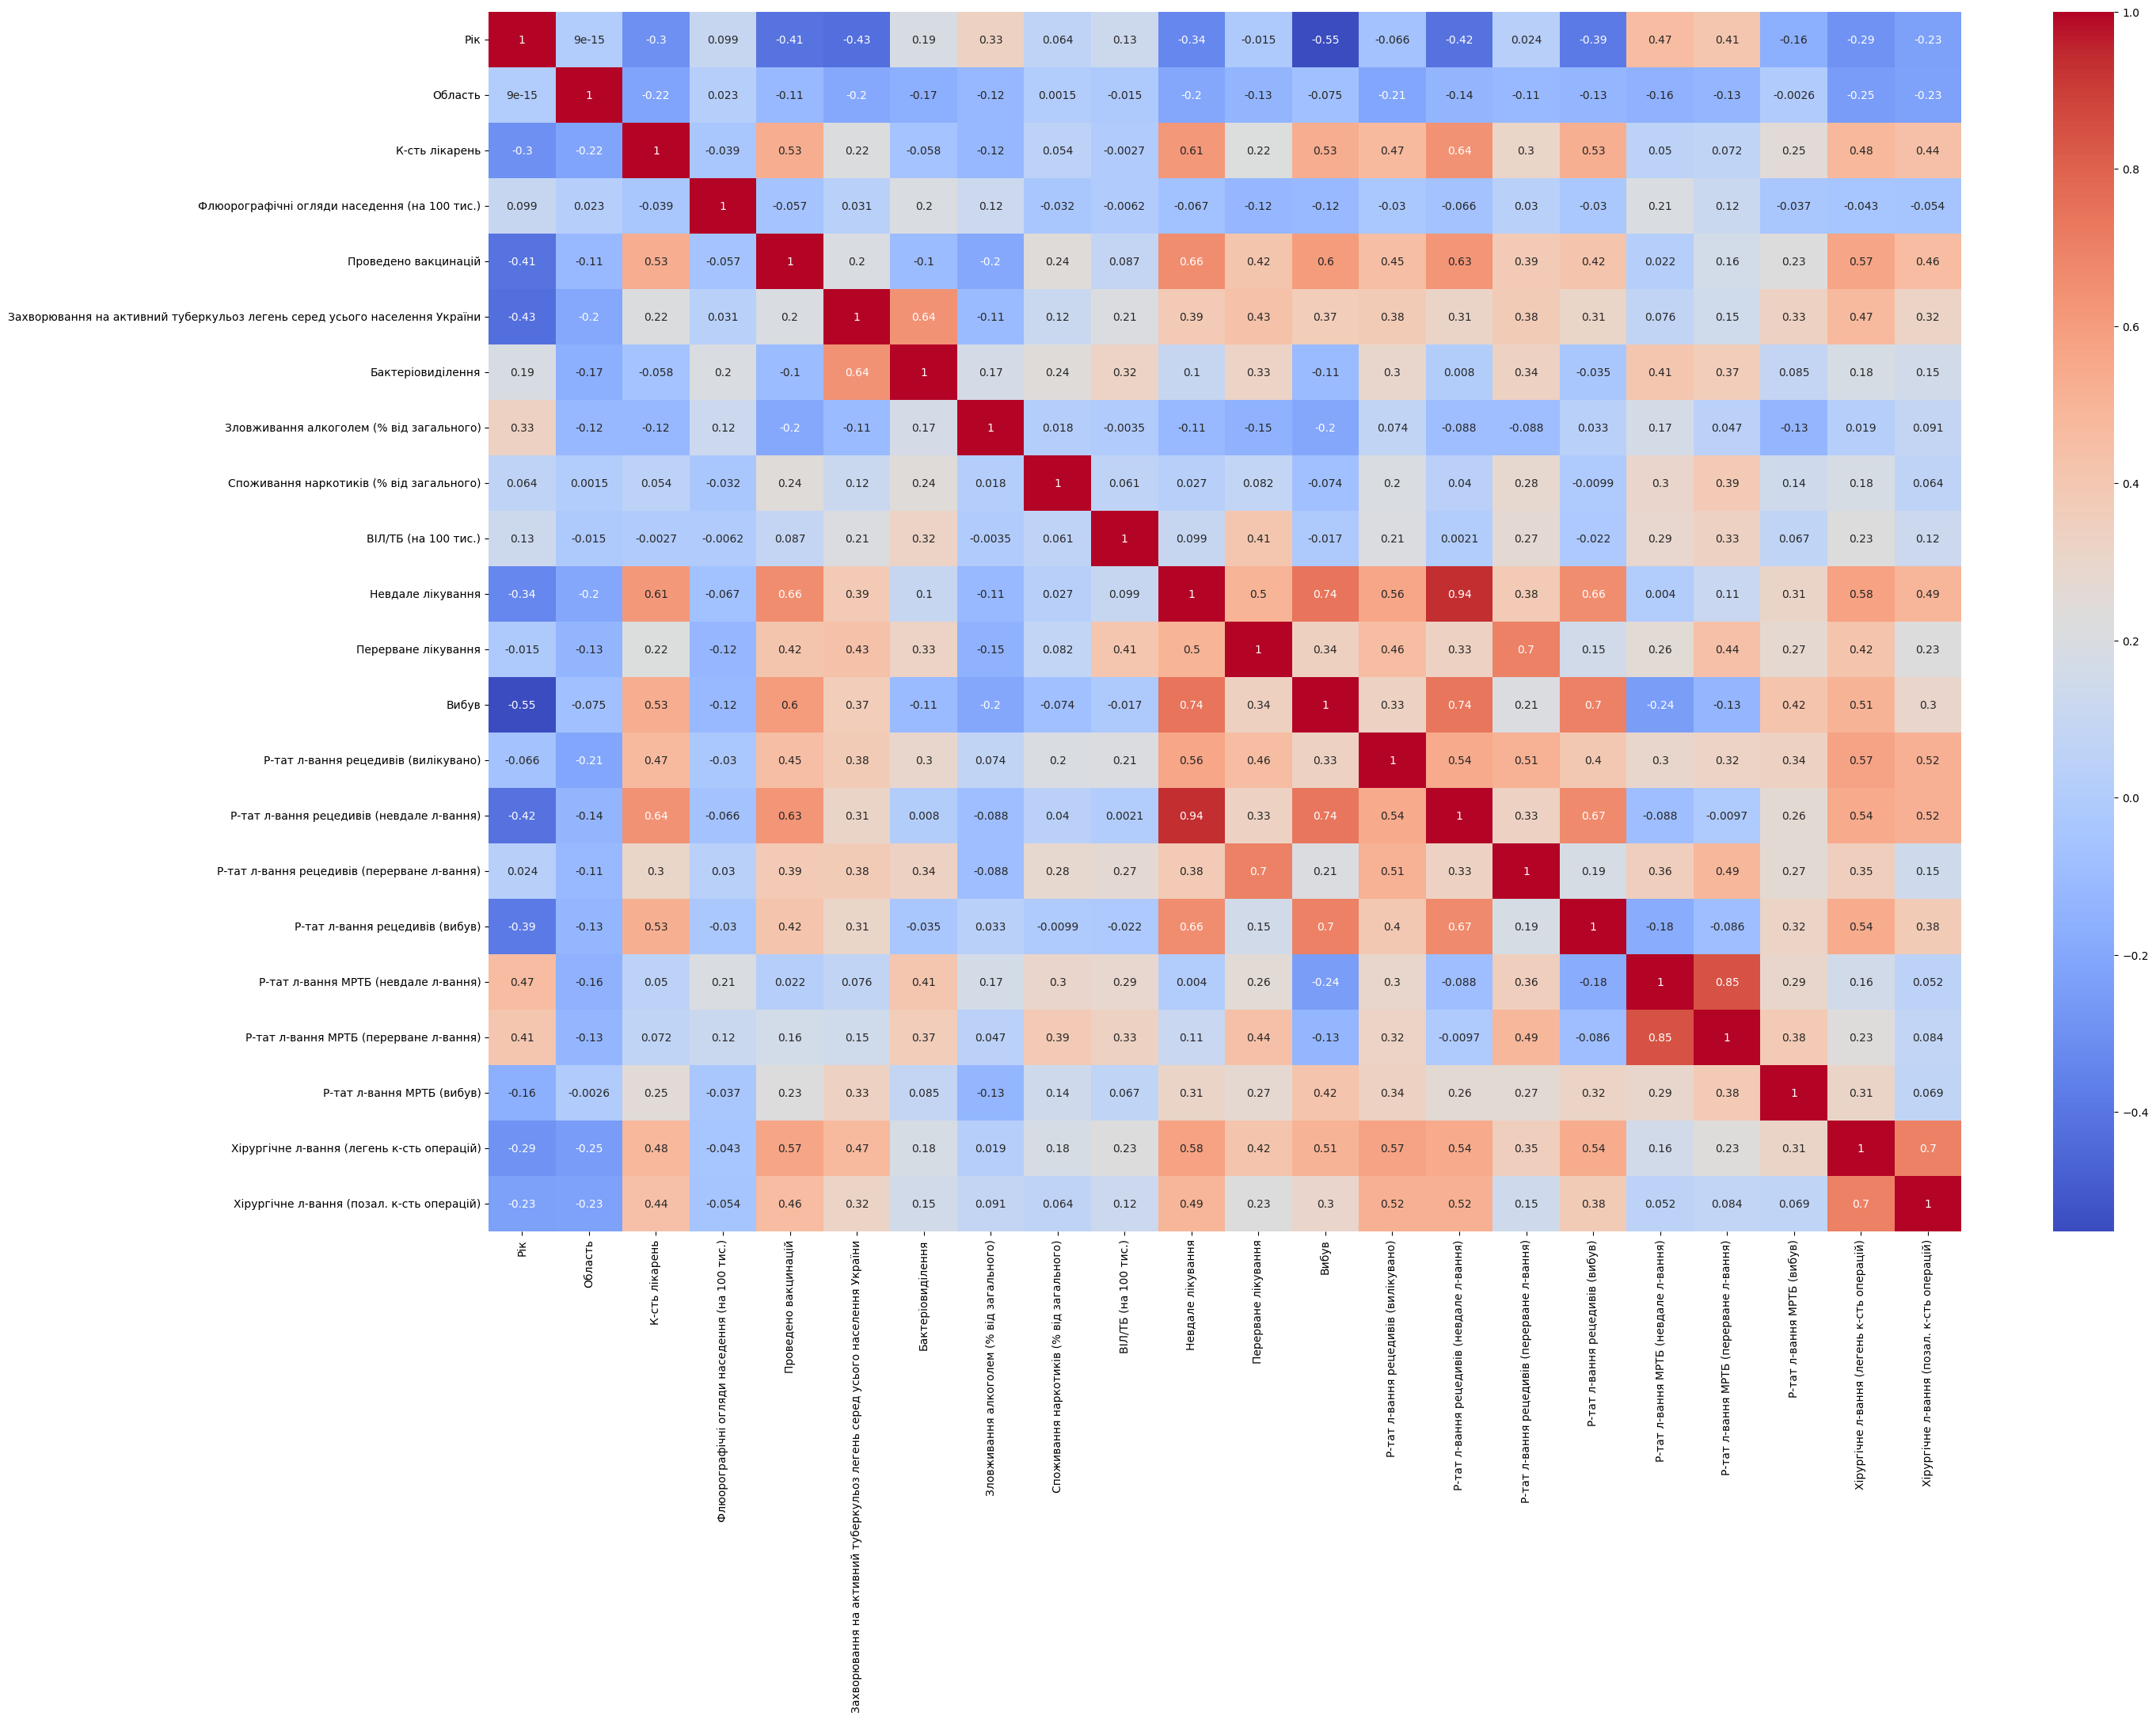

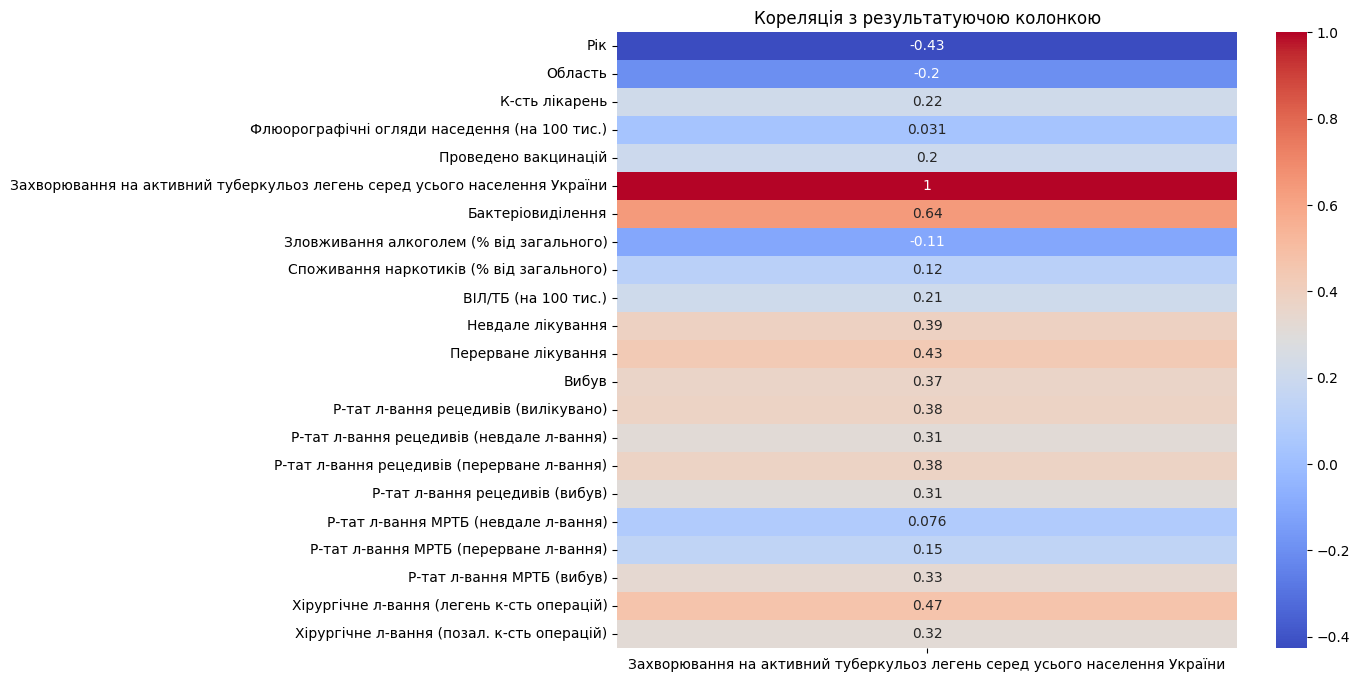

In [41]:
correlation_matrix = df_temp.corr()
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

plt.figure(figsize=(10, 8))
result_column_corr = correlation_matrix['Захворювання на активний туберкульоз легень серед усього населення України']
# print(result_column_corr)
sns.heatmap(result_column_corr.to_frame(), annot=True, cmap='coolwarm')
plt.title('Кореляція з результатуючою колонкою')
plt.show()

#### Histogram

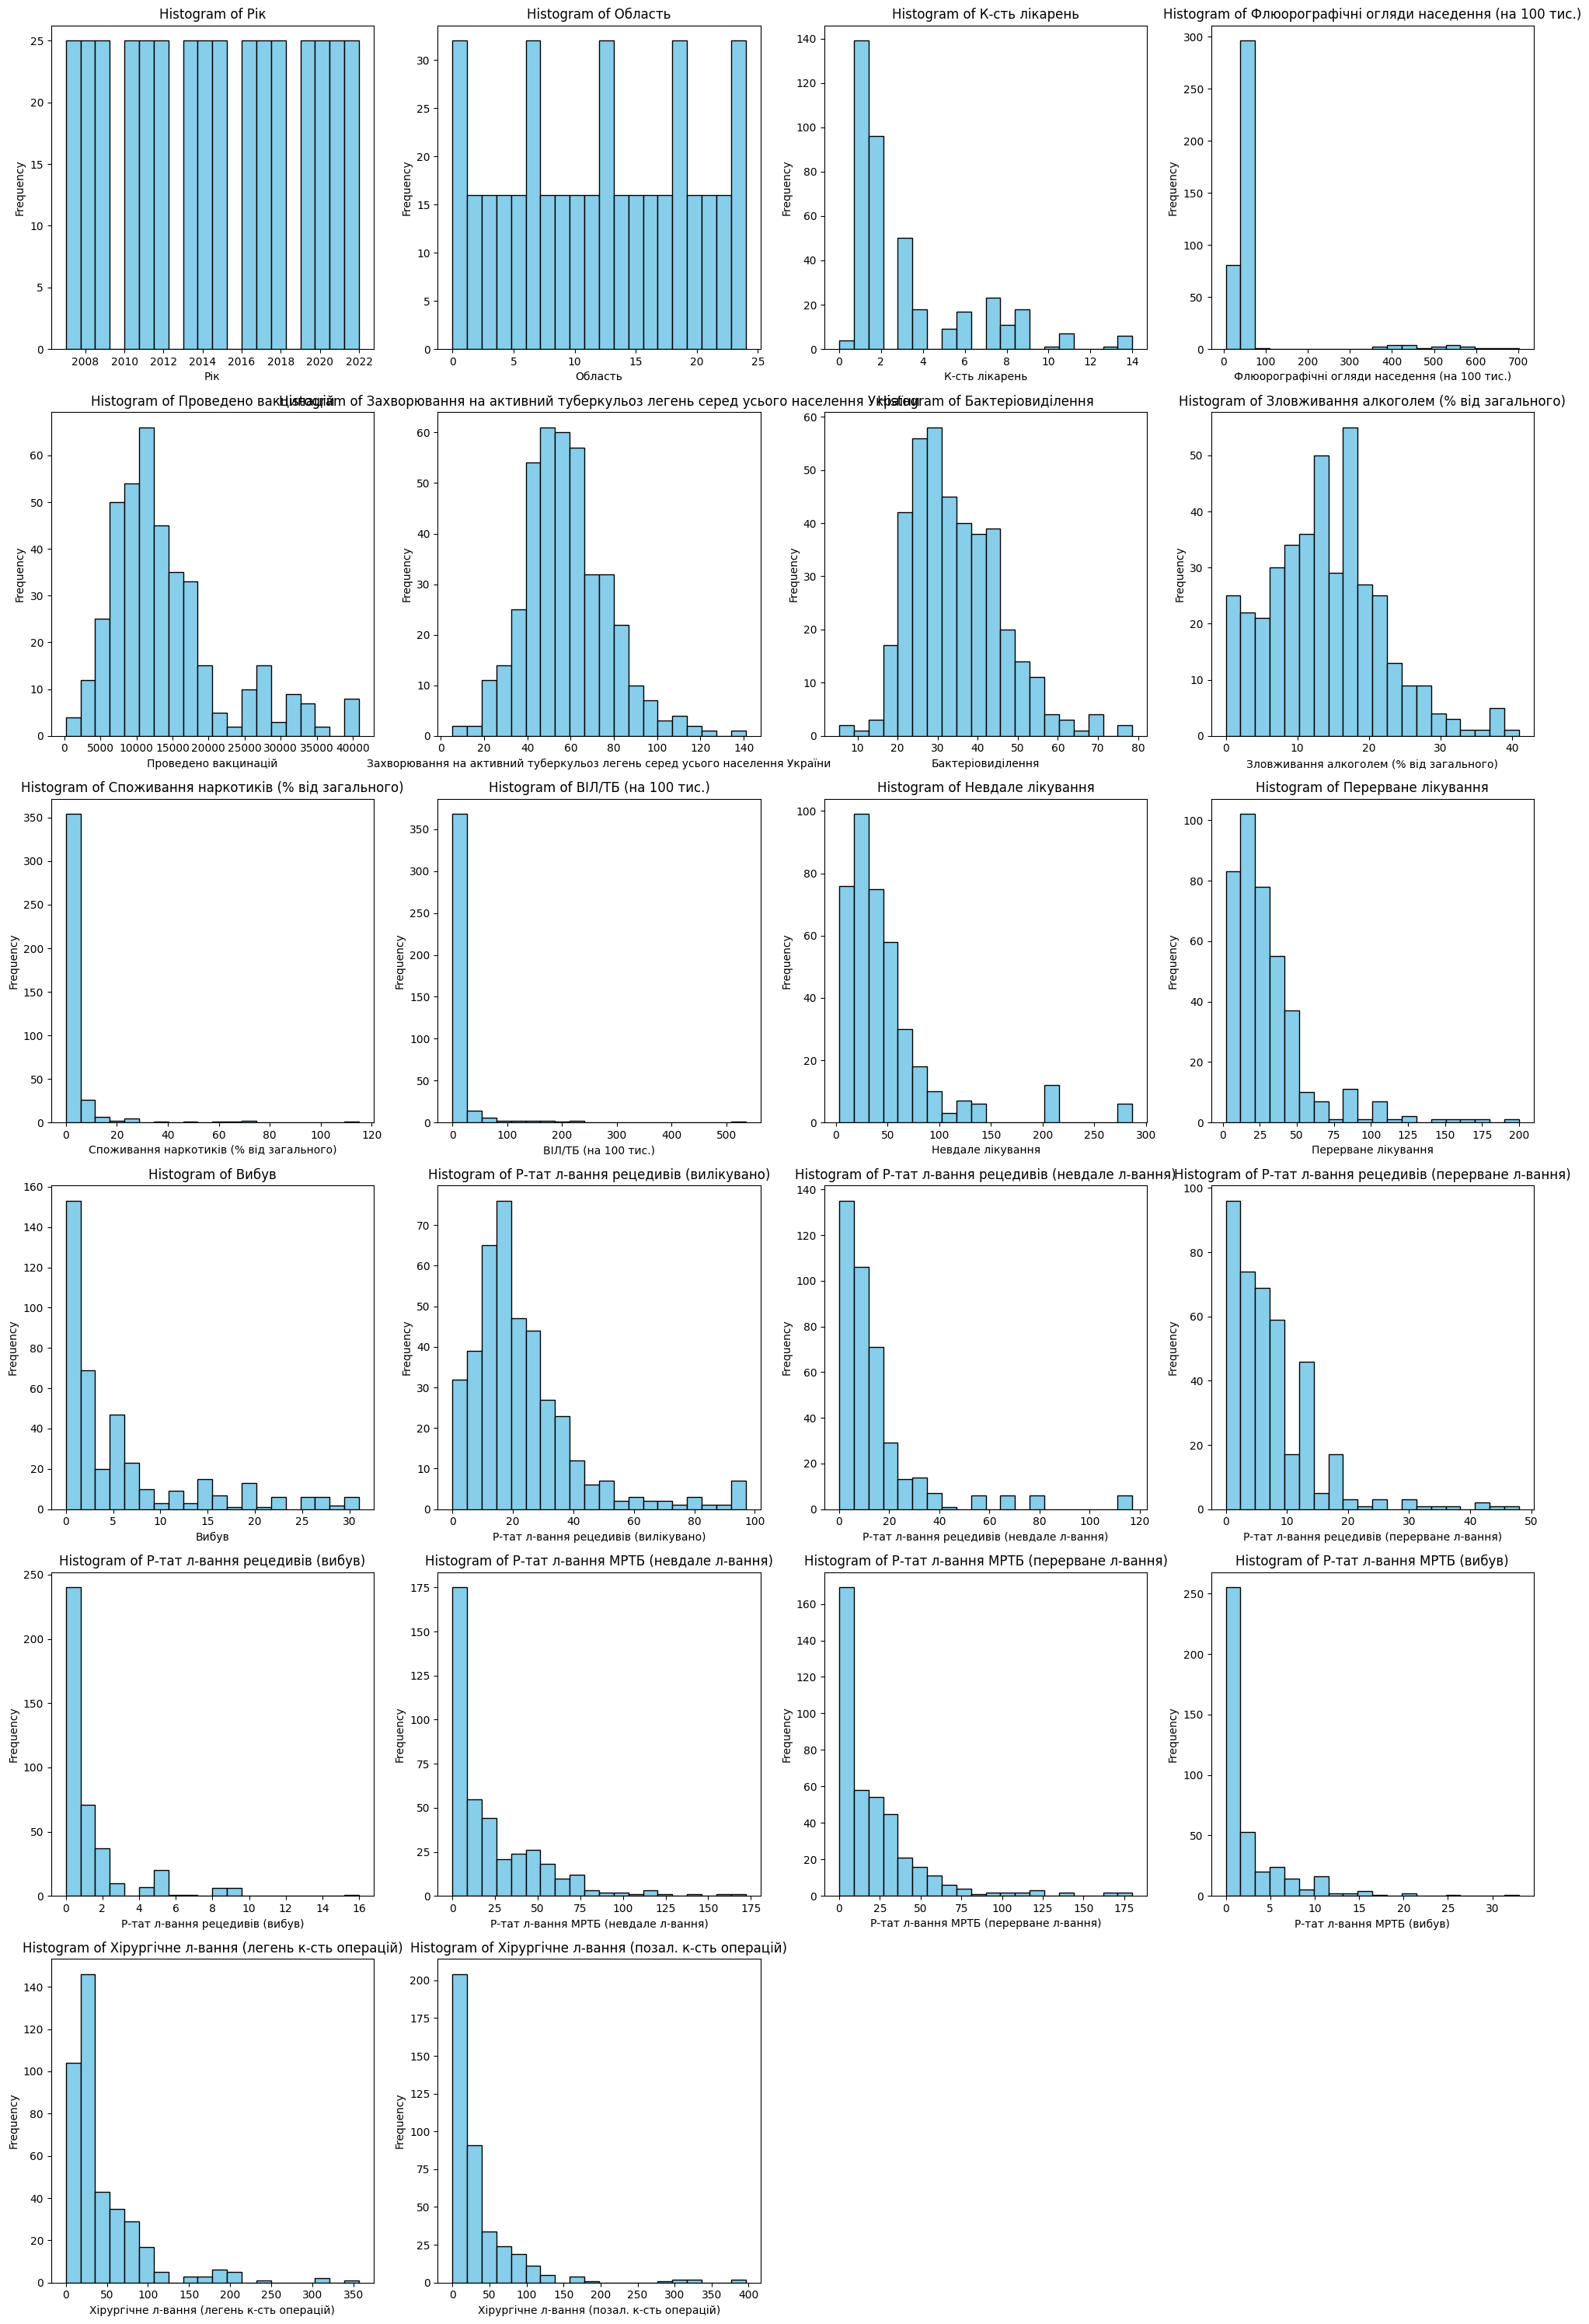

In [42]:
numerical_columns = df_temp.select_dtypes(include=['int64', 'float64']).columns

num_plots = len(numerical_columns)
num_rows = (num_plots + 3) // 4 

fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows*5))
for i, column in enumerate(numerical_columns):
    ax = axes[i // 4, i % 4] 
    df[column].hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(False)

for i in range(num_plots, num_rows * 4):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### Feature selection

In [43]:
X.shape

(400, 21)

In [44]:
X

,Рік,Область,К-сть лікарень,Флюорографічні огляди наседення (на 100 тис.),Проведено вакцинацій,Бактеріовиділення,Зловживання алкоголем (% від загального),Споживання наркотиків (% від загального),ВІЛ/ТБ (на 100 тис.),Невдале лікування,...,Вибув,Р-тат л-вання рецедивів (вилікувано),Р-тат л-вання рецедивів (невдале л-вання),Р-тат л-вання рецедивів (перерване л-вання),Р-тат л-вання рецедивів (вибув),Р-тат л-вання МРТБ (невдале л-вання),Р-тат л-вання МРТБ (перерване л-вання),Р-тат л-вання МРТБ (вибув),Хірургічне л-вання (легень к-сть операцій),Хірургічне л-вання (позал. к-сть операцій)
0,2007,0,7,50.6,16152,29.4,6.4,0.8,0.5,34,...,7,23,4,0,0,0,0,1,27,91
1,2007,1,1,47.3,14620,30.3,18.2,2.2,1.5,16,...,2,1,8,0,0,0,0,0,95,121
2,2007,2,2,65.2,16421,28.2,2.0,0.1,1.5,56,...,12,15,20,4,1,3,9,5,26,30
3,2007,3,6,69.1,34346,33.0,9.3,5.3,6.5,209,...,31,37,67,17,8,8,29,10,95,10
4,2007,4,14,55.4,40865,33.9,37.2,8.3,13.8,287,...,27,97,117,8,9,25,26,6,186,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2022,20,1,31.7,6456,22.2,8.0,0.0,5.1,28,...,0,36,10,4,0,3,8,0,8,5
396,2022,21,1,29.0,6153,32.2,14.1,3.0,7.7,57,...,0,22,17,3,0,12,16,0,39,6
397,2022,22,1,29.0,6135,27.8,23.4,3.2,1.8,9,...,0,13,2,3,0,2,4,0,0,0
398,2022,23,1,27.8,3866,27.6,4.7,0.3,6.5,18,...,4,3,1,3,0,10,24,0,34,0


In [45]:
X_train = X[df['Рік'] <= 2020]
X_test = X[df['Рік'] > 2020]
y_train = y[df['Рік'] <= 2020]
y_test = y[df['Рік'] > 2020]


# X_train = X[:350]
# X_test = X[350:]
# y_train = y[:350]
# y_test = y[350:]

In [46]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(X.shape, y.shape)

(350, 21) (50, 21)
(350, 1) (50, 1)
(400, 21) (400, 1)


In [47]:
X.index

RangeIndex(start=0, stop=400, step=1)

In [48]:
assessment_results = pd.DataFrame(columns=['Regressor', 'Feature_Selection', 'Correlation_train', 'Correlation_test', 'Mean_Absolute_Error_train', 'Mean_Absolute_Error_test', 'Mean_Squared_Error_train', 'Mean_Squared_Error_test', 'Root_Mean_Squared_Error_train', 'Root_Mean_Squared_Error_test'])

In [49]:

def plot_predictions_with_regions(X_train, y_train, y_pred_train, X_test, y_test, y_pred_test, region_mapping):
    X_train_with_region = X_train.replace({'Область': region_mapping})
    X_test_with_region = X_test.replace({'Область': region_mapping})
    
    train_data = pd.DataFrame({'Рік': X_train_with_region['Рік'].astype(int), 'Область': X_train_with_region['Область'], 'Actual_train': y_train.values.flatten(), 'Predicted_train': y_pred_train.flatten()})
    test_data = pd.DataFrame({'Рік': X_test_with_region['Рік'].astype(int), 'Область': X_test_with_region['Область'], 'Actual_test': y_test.values.flatten(), 'Predicted_test': y_pred_test.flatten()})
    
    regions = train_data['Область'].unique()
    num_regions = len(regions)
    num_cols = 5  
    num_rows = (num_regions + num_cols - 1) // num_cols  
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))
    
    for i, region in enumerate(regions):
        row = i // num_cols
        col = i % num_cols
        
        region_data_train = train_data[train_data['Область'] == region]
        region_data_test = test_data[test_data['Область'] == region]
        
        ax = axes[row, col]
        ax.plot(region_data_train['Рік'], region_data_train['Actual_train'], label='Actual train')
        ax.plot(region_data_train['Рік'], region_data_train['Predicted_train'], label='Predicted train')
        ax.plot(region_data_test['Рік'], region_data_test['Actual_test'], label='Actual test')
        ax.plot(region_data_test['Рік'], region_data_test['Predicted_test'], label='Predicted test')
        
        ax.set_title(f'Predicted vs Real Values for Область: {region}')
        ax.set_xlabel('Рік')
        ax.set_ylabel('Occurences')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()


def model_assessment(regressor, feature_selection_method, X_train, X_test, y_train, y_test, _X_train, _X_test):
    regressor.fit(X_train, y_train)

    y_pred_train = regressor.predict(X_train)
    y_pred_test = regressor.predict(X_test)

    results = {
        'Regressor': type(regressor).__name__,
        'Feature_Selection': feature_selection_method,
        # 'Correlation_train': regressor.score(X_train, y_train),
        # 'Correlation_test': regressor.score(X_test, y_test),
        'Correlation_train': r2_score(y_train, y_pred_train),
        'Correlation_test': r2_score(y_test, y_pred_test),
        'Mean_Absolute_Error_train': mean_absolute_error(y_train, y_pred_train),
        'Mean_Absolute_Error_test': mean_absolute_error(y_test, y_pred_test),
        'Mean_Squared_Error_train': mean_squared_error(y_train, y_pred_train),
        'Mean_Squared_Error_test': mean_squared_error(y_test, y_pred_test),
        'Root_Mean_Squared_Error_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Root_Mean_Squared_Error_test': np.sqrt(mean_squared_error(y_test, y_pred_test))
    }

    print("Regressor:", results['Regressor'])
    print("Correlation train:", results['Correlation_train'])
    print("Correlation test:", results['Correlation_test'])
    print("Mean Absolute Error (train):", results['Mean_Absolute_Error_train'])
    print("Mean Absolute Error (test):", results['Mean_Absolute_Error_test'])
    print("Mean Squared Error (train):", results['Mean_Squared_Error_train'])
    print("Mean Squared Error (test):", results['Mean_Squared_Error_test'])
    print("Root Mean Squared Error (train):", results['Root_Mean_Squared_Error_train'])
    print("Root Mean Squared Error (test):", results['Root_Mean_Squared_Error_test'])

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']
    for score in scoring:
        scores = cross_val_score(regressor, pd.concat([X_train, X_test], axis=0), y, cv=cv, scoring=score)
        score_mean = np.mean(scores)
        score_std = np.std(scores)
        print('Metric', score, '\tMean', score_mean, '\tStd', score_std)
        results['Cross_Validation_Mean_' + score] = score_mean
        results['Cross_Validation_Std_' + score] = score_std

    global assessment_results
    assessment_results = assessment_results._append(results, ignore_index=True)

    if hasattr(regressor, 'coef_'):  
        print("Feature coefs:")
        coef = regressor.coef_
        if type(regressor.coef_[0]) == np.ndarray:
            coef = regressor.coef_[0]
        for s in zip(X_train.columns, coef):
            print(s[0], ":", s[1])

    if hasattr(regressor, 'feature_importances_'):  
        print("Feature Importances:")
        for feature, importance in zip(X_train.columns, regressor.feature_importances_):
            print(f"{feature}: {importance}")

    if hasattr(regressor, 'intercept_'):  
        print("Intercept", regressor.intercept_)

    else:
        print(type(regressor).__name__, "does not have feature intercept.")


    # plot_predictions_with_regions(_X_train, y_train, y_pred_train, _X_test, y_test, y_pred_test, region_mapping)


def sensitivity_test(regressor_class, X, y, epsilon=0.01):
    regressor = regressor_class()
    regressor.fit(X, y)           
    y_pred = regressor.predict(X.iloc[-1:])
    y_pred_delta = regressor.predict(X.iloc[-1:]*(1+epsilon))
    sensitivity = abs(((y_pred_delta - y_pred) / y_pred)[0][0]) * 100
    # print(sensitivity)
    return "{:.2f}%".format(sensitivity)

In [50]:
X_train.columns

Index(['Рік', 'Область', 'К-сть лікарень',
       'Флюорографічні огляди наседення (на 100 тис.)', 'Проведено вакцинацій',
       'Бактеріовиділення', 'Зловживання алкоголем (% від загального)',
       'Споживання наркотиків (% від загального)', 'ВІЛ/ТБ (на 100 тис.)',
       'Невдале лікування', 'Перерване лікування', 'Вибув',
       'Р-тат л-вання рецедивів (вилікувано)',
       'Р-тат л-вання рецедивів (невдале л-вання)',
       'Р-тат л-вання рецедивів (перерване л-вання)',
       'Р-тат л-вання рецедивів (вибув)',
       'Р-тат л-вання МРТБ (невдале л-вання)',
       'Р-тат л-вання МРТБ (перерване л-вання)', 'Р-тат л-вання МРТБ (вибув)',
       'Хірургічне л-вання (легень к-сть операцій)',
       'Хірургічне л-вання (позал. к-сть операцій)'],
      dtype='object')

### Linear Regression test

#### No Feature Importance

In [51]:
regressor = LinearRegression()

model_assessment(regressor, 'No Feature Selection', X_train, X_test, y_train, y_test, X_train, X_test)

Regressor: LinearRegression
Correlation train: 0.7829511171014556
Correlation test: 0.8078328802717833
Mean Absolute Error (train): 6.438717309267813
Mean Absolute Error (test): 5.52846570838781
Mean Squared Error (train): 69.86270044980945
Mean Squared Error (test): 52.39916245387518
Root Mean Squared Error (train): 8.358391020394382
Root Mean Squared Error (test): 7.238726576814128
Metric neg_mean_squared_error 	Mean -80.5949693334729 	Std 16.41974881387671
Metric r2 	Mean 0.7813963528396013 	Std 0.04386789127668057
Metric neg_mean_absolute_error 	Mean -6.832028137457587 	Std 0.5958541203218508
Feature coefs:
Рік : -2.1174778228509035
Область : -0.09721010788681103
К-сть лікарень : 0.15294489537868977
Флюорографічні огляди наседення (на 100 тис.) : -0.003145147497466459
Проведено вакцинацій : -0.000562079026844269
Бактеріовиділення : 1.0741881479219246
Зловживання алкоголем (% від загального) : -0.03785339604934477
Споживання наркотиків (% від загального) : -0.030202217069737625
ВІЛ/

#### Select K best 

In [52]:
selector = SelectKBest(score_func=f_regression, k=10)

X_train_selected_array = selector.fit_transform(X_train, y_train)
X_train_selected = pd.DataFrame(X_train_selected_array, columns=X_train.columns[selector.get_support()])

X_test_selected_array = selector.transform(X_test)
X_test_selected = pd.DataFrame(X_test_selected_array, columns=X_train.columns[selector.get_support()])
print(X_test_selected.columns)

regressor = LinearRegression()

model_assessment(regressor, 'Select K best', X_train_selected, X_test_selected, y_train, y_test, X_train, X_test)

Index(['Рік', 'Бактеріовиділення', 'Невдале лікування', 'Перерване лікування',
       'Вибув', 'Р-тат л-вання рецедивів (вилікувано)',
       'Р-тат л-вання рецедивів (перерване л-вання)',
       'Р-тат л-вання рецедивів (вибув)', 'Р-тат л-вання МРТБ (вибув)',
       'Хірургічне л-вання (легень к-сть операцій)'],
      dtype='object')
Regressor: LinearRegression
Correlation train: 0.7401736176655994
Correlation test: 0.8413898530711706
Mean Absolute Error (train): 7.019884954323398
Mean Absolute Error (test): 4.476028486851767
Mean Squared Error (train): 83.63172606822768
Mean Squared Error (test): 43.249016103853265
Root Mean Squared Error (train): 9.145038330604617
Root Mean Squared Error (test): 6.576398414318681
Metric neg_mean_squared_error 	Mean -86.9659909563296 	Std 18.718226254037816
Metric r2 	Mean 0.7656113753176964 	Std 0.0464815923955508
Metric neg_mean_absolute_error 	Mean -7.025354024173159 	Std 0.8003703747580427
Feature coefs:
Рік : -2.131243279816727
Бактеріовиділення

#### RFE


In [53]:
selector = RFE(estimator=LinearRegression(), n_features_to_select=10)

selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

regressor = LinearRegression()

model_assessment(regressor, 'RFE', X_train_selected, X_test_selected, y_train, y_test, X_train, X_test)

Regressor: LinearRegression
Correlation train: 0.74409614632642
Correlation test: 0.8290069907770242
Mean Absolute Error (train): 7.04429564979191
Mean Absolute Error (test): 5.064834537821829
Mean Squared Error (train): 82.3691605061428
Mean Squared Error (test): 46.6255126341266
Root Mean Squared Error (train): 9.075745727274581
Root Mean Squared Error (test): 6.828287679508429
Metric neg_mean_squared_error 	Mean -83.14597162376685 	Std 13.303665425027587
Metric r2 	Mean 0.77395282269251 	Std 0.04083822655976231
Metric neg_mean_absolute_error 	Mean -6.992457178504988 	Std 0.45136239025595676
Feature coefs:
Рік : -2.2860826314732776
Область : -0.15748773506201585
Бактеріовиділення : 1.192245167153447
Споживання наркотиків (% від загального) : -0.09299605865908925
Невдале лікування : 0.09246410659923426
Вибув : 0.22763131110115592
Р-тат л-вання рецедивів (невдале л-вання) : -0.3202888776142171
Р-тат л-вання рецедивів (перерване л-вання) : 0.31838977465107665
Р-тат л-вання рецедивів (ви

#### Sens test

In [54]:

for column in X.columns[:-1]:
    print(f"Sensitivity for {column}:", sensitivity_test(LinearRegression, df[[column]], y, 0.1))

Sensitivity for Рік: 815.15%
Sensitivity for Область: 2.48%
Sensitivity for К-сть лікарень: 0.26%
Sensitivity for Флюорографічні огляди наседення (на 100 тис.): 0.01%
Sensitivity for Проведено вакцинацій: 1.44%
Sensitivity for Бактеріовиділення: 4.84%
Sensitivity for Зловживання алкоголем (% від загального): 0.17%
Sensitivity for Споживання наркотиків (% від загального): 0.09%
Sensitivity for ВІЛ/ТБ (на 100 тис.): 0.10%
Sensitivity for Невдале лікування: 1.03%
Sensitivity for Перерване лікування: 1.41%
Sensitivity for Вибув: 0.68%
Sensitivity for Р-тат л-вання рецедивів (вилікувано): 1.26%
Sensitivity for Р-тат л-вання рецедивів (невдале л-вання): 0.17%
Sensitivity for Р-тат л-вання рецедивів (перерване л-вання): 0.76%
Sensitivity for Р-тат л-вання рецедивів (вибув): 0.00%
Sensitivity for Р-тат л-вання МРТБ (невдале л-вання): 0.24%
Sensitivity for Р-тат л-вання МРТБ (перерване л-вання): 0.40%
Sensitivity for Р-тат л-вання МРТБ (вибув): 0.56%
Sensitivity for Хірургічне л-вання (легень к

### Ridge test

#### No Feature Importance

In [55]:
regressor = Ridge()

model_assessment(regressor, 'No Feature Selection', X_train, X_test, y_train, y_test, X_train, X_test)

Regressor: Ridge
Correlation train: 0.7829510975054321
Correlation test: 0.8077819332416317
Mean Absolute Error (train): 6.438669936811202
Mean Absolute Error (test): 5.5300686980506715
Mean Squared Error (train): 69.86270675728773
Mean Squared Error (test): 52.41305443348768
Root Mean Squared Error (train): 8.358391397708516
Root Mean Squared Error (test): 7.239686072854795
Metric neg_mean_squared_error 	Mean -80.58989559012305 	Std 16.41597866229958
Metric r2 	Mean 0.7814108970896857 	Std 0.04385709814470829
Metric neg_mean_absolute_error 	Mean -6.831776688573969 	Std 0.5955462923656095
Feature coefs:
Рік : -2.116529731126613
Область : -0.09725272233238247
К-сть лікарень : 0.1527290156600522
Флюорографічні огляди наседення (на 100 тис.) : -0.003146309150236319
Проведено вакцинацій : -0.0005620224075629185
Бактеріовиділення : 1.074154241085348
Зловживання алкоголем (% від загального) : -0.037999332649330135
Споживання наркотиків (% від загального) : -0.030182877457166427
ВІЛ/ТБ (на 10

#### Select K best 

In [56]:
selector = SelectKBest(score_func=f_regression, k=10)

X_train_selected_array = selector.fit_transform(X_train, y_train)
X_train_selected = pd.DataFrame(X_train_selected_array, columns=X_train.columns[selector.get_support()])

X_test_selected_array = selector.transform(X_test)
X_test_selected = pd.DataFrame(X_test_selected_array, columns=X_train.columns[selector.get_support()])
print(X_test_selected.columns)

regressor = Ridge()

model_assessment(regressor,'Select K best', X_train_selected, X_test_selected, y_train, y_test, X_train, X_test)

Index(['Рік', 'Бактеріовиділення', 'Невдале лікування', 'Перерване лікування',
       'Вибув', 'Р-тат л-вання рецедивів (вилікувано)',
       'Р-тат л-вання рецедивів (перерване л-вання)',
       'Р-тат л-вання рецедивів (вибув)', 'Р-тат л-вання МРТБ (вибув)',
       'Хірургічне л-вання (легень к-сть операцій)'],
      dtype='object')
Regressor: Ridge
Correlation train: 0.7401736008764344
Correlation test: 0.8414583755062204
Mean Absolute Error (train): 7.019745227997197
Mean Absolute Error (test): 4.474721683498221
Mean Squared Error (train): 83.63173147224725
Mean Squared Error (test): 43.23033175134288
Root Mean Squared Error (train): 9.145038626066444
Root Mean Squared Error (test): 6.574977699684074
Metric neg_mean_squared_error 	Mean -86.96356593014494 	Std 18.715860589523082
Metric r2 	Mean 0.7656178433949596 	Std 0.04647662178564698
Metric neg_mean_absolute_error 	Mean -7.025097735516077 	Std 0.8001536770742668
Feature coefs:
Рік : -2.130609770926684
Бактеріовиділення : 1.16608

#### RFE


In [57]:
selector = RFE(estimator=Ridge(), n_features_to_select=10)

selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

regressor = Ridge()

model_assessment(regressor, 'RFE', X_train_selected, X_test_selected, y_train, y_test, X_train, X_test)

Regressor: Ridge
Correlation train: 0.7440961268658829
Correlation test: 0.82909902614541
Mean Absolute Error (train): 7.044198244272345
Mean Absolute Error (test): 5.063029261381511
Mean Squared Error (train): 82.36916677001135
Mean Squared Error (test): 46.60041689336527
Root Mean Squared Error (train): 9.075746072362941
Root Mean Squared Error (test): 6.826449801570745
Metric neg_mean_squared_error 	Mean -83.14124780320081 	Std 13.302384220631396
Metric r2 	Mean 0.7739666339833132 	Std 0.0408305522843269
Metric neg_mean_absolute_error 	Mean -6.9922310575225906 	Std 0.4513306105121601
Feature coefs:
Рік : -2.285385348922906
Область : -0.15750134094022583
Бактеріовиділення : 1.1921741450466048
Споживання наркотиків (% від загального) : -0.09297464496911265
Невдале лікування : 0.09244734723542702
Вибув : 0.22789091896939462
Р-тат л-вання рецедивів (невдале л-вання) : -0.32019859545819107
Р-тат л-вання рецедивів (перерване л-вання) : 0.318309245890803
Р-тат л-вання рецедивів (вибув) : 0

#### Sens test

In [58]:

for column in X.columns[:-1]:
    print(f"Sensitivity for {column}:", sensitivity_test(Ridge, df[[column]], y, 0.1))

Sensitivity for Рік: 815.03%
Sensitivity for Область: 2.48%
Sensitivity for К-сть лікарень: 0.26%
Sensitivity for Флюорографічні огляди наседення (на 100 тис.): 0.01%
Sensitivity for Проведено вакцинацій: 1.44%
Sensitivity for Бактеріовиділення: 4.84%
Sensitivity for Зловживання алкоголем (% від загального): 0.17%
Sensitivity for Споживання наркотиків (% від загального): 0.09%
Sensitivity for ВІЛ/ТБ (на 100 тис.): 0.10%
Sensitivity for Невдале лікування: 1.03%
Sensitivity for Перерване лікування: 1.41%
Sensitivity for Вибув: 0.68%
Sensitivity for Р-тат л-вання рецедивів (вилікувано): 1.26%
Sensitivity for Р-тат л-вання рецедивів (невдале л-вання): 0.17%
Sensitivity for Р-тат л-вання рецедивів (перерване л-вання): 0.76%
Sensitivity for Р-тат л-вання рецедивів (вибув): 0.00%
Sensitivity for Р-тат л-вання МРТБ (невдале л-вання): 0.24%
Sensitivity for Р-тат л-вання МРТБ (перерване л-вання): 0.40%
Sensitivity for Р-тат л-вання МРТБ (вибув): 0.55%
Sensitivity for Хірургічне л-вання (легень к

### Lasso test

#### No Feature Importance

In [59]:
regressor = Lasso()

model_assessment(regressor, 'No Feature Selection', X_train, X_test, y_train, y_test, X_train, X_test)

Regressor:

 Lasso
Correlation train: 0.7813203637686833
Correlation test: 0.7938771994276611
Mean Absolute Error (train): 6.448808215156061
Mean Absolute Error (test): 5.863962792140995
Mean Squared Error (train): 70.38759986451066
Mean Squared Error (test): 56.204527225641684
Root Mean Squared Error (train): 8.389731811238704
Root Mean Squared Error (test): 7.496967868788134
Metric neg_mean_squared_error 	Mean -79.47336116838477 	Std 16.559590551867966
Metric r2 	Mean 0.785019565318384 	Std 0.04286479604972131
Metric neg_mean_absolute_error 	Mean -6.779258752872759 	Std 0.5630230330123297
Feature coefs:
Рік : -1.9866889035043365
Область : -0.09046350543970266
К-сть лікарень : 0.0
Флюорографічні огляди наседення (на 100 тис.) : -0.0032718311567907226
Проведено вакцинацій : -0.0005439508558239416
Бактеріовиділення : 1.056199560580049
Зловживання алкоголем (% від загального) : -0.05003175674629216
Споживання наркотиків (% від загального) : -0.01396291406473205
ВІЛ/ТБ (на 100 тис.) : -0.017288130255

#### Select K best 

In [60]:
selector = SelectKBest(score_func=f_regression, k=10)

X_train_selected_array = selector.fit_transform(X_train, y_train)
X_train_selected = pd.DataFrame(X_train_selected_array, columns=X_train.columns[selector.get_support()])

X_test_selected_array = selector.transform(X_test)
X_test_selected = pd.DataFrame(X_test_selected_array, columns=X_train.columns[selector.get_support()])
print(X_test_selected.columns)

regressor = Lasso()

model_assessment(regressor,'Select K best', X_train_selected, X_test_selected, y_train, y_test, X_train, X_test)

Index(['Рік', 'Бактеріовиділення', 'Невдале лікування', 'Перерване лікування',
       'Вибув', 'Р-тат л-вання рецедивів (вилікувано)',
       'Р-тат л-вання рецедивів (перерване л-вання)',
       'Р-тат л-вання рецедивів (вибув)', 'Р-тат л-вання МРТБ (вибув)',
       'Хірургічне л-вання (легень к-сть операцій)'],
      dtype='object')
Regressor: Lasso
Correlation train: 0.7381856117646637
Correlation test: 0.8534778121868368
Mean Absolute Error (train): 7.015886246682805
Mean Absolute Error (test): 4.2008729373991995
Mean Squared Error (train): 84.27161630352757
Mean Squared Error (test): 39.95293228715552
Root Mean Squared Error (train): 9.17995731490771
Root Mean Squared Error (test): 6.32083319564403
Metric neg_mean_squared_error 	Mean -86.68667745691207 	Std 17.887703595135836
Metric r2 	Mean 0.7660487860147034 	Std 0.045654775895005204
Metric neg_mean_absolute_error 	Mean -7.008468781576323 	Std 0.7373619373496512
Feature coefs:
Рік : -2.0309948817797885
Бактеріовиділення : 1.1486

#### RFE


In [61]:
selector = RFE(estimator=Lasso(), n_features_to_select=10)

selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

regressor = Lasso()

model_assessment(regressor, 'RFE', X_train_selected, X_test_selected, y_train, y_test, X_train, X_test)

Regressor: Lasso
Correlation train: 0.7442890341930846
Correlation test: 0.8406487600972972
Mean Absolute Error (train): 7.0156570281527895
Mean Absolute Error (test): 4.873956515762598
Mean Squared Error (train): 82.30707464295271
Mean Squared Error (test): 43.45109360382486
Root Mean Squared Error (train): 9.07232465484744
Root Mean Squared Error (test): 6.591744352129022
Metric neg_mean_squared_error 	Mean -82.20962621385618 	Std 11.995079888958529
Metric r2 	Mean 0.7766296231578229 	Std 0.036625131337707825
Metric neg_mean_absolute_error 	Mean -6.926845007716983 	Std 0.42361295258504333
Feature coefs:
Рік : -1.9952585778510195
Область : -0.1744617609489045
Бактеріовиділення : 1.1976712853866263
Споживання наркотиків (% від загального) : -0.060732593687611997
Невдале лікування : 0.09672688188946393
Вибув : 0.22573707698476098
Р-тат л-вання рецедивів (невдале л-вання) : -0.27716872081484434
Р-тат л-вання рецедивів (перерване л-вання) : 0.3091453012554616
Р-тат л-вання МРТБ (невдале л

#### Sens test

In [62]:
def sensitivity_test(regressor_class, X, y, epsilon=0.01):
    """
    Perform sensitivity test by perturbing each feature by epsilon and observing the change in predictions.
    """
    regressor = regressor_class()
    regressor.fit(X, y)           
    y_pred = regressor.predict(X.iloc[-1:])
    y_pred_delta = regressor.predict(X.iloc[-1:]*(1+epsilon))
    sensitivity = abs(((y_pred_delta - y_pred) / y_pred)[0]) * 100
    # print(sensitivity)
    return "{:.2f}%".format(sensitivity)

for column in X.columns[:-1]:
    print(f"Sensitivity for {column}:", sensitivity_test(Lasso, df[[column]], y, 0.1))

Sensitivity for Рік: 787.50%
Sensitivity for Область: 2.38%
Sensitivity for К-сть лікарень: 0.24%
Sensitivity for Флюорографічні огляди наседення (на 100 тис.): 0.01%
Sensitivity for Проведено вакцинацій: 1.44%
Sensitivity for Бактеріовиділення: 4.79%
Sensitivity for Зловживання алкоголем (% від загального): 0.16%
Sensitivity for Споживання наркотиків (% від загального): 0.09%
Sensitivity for ВІЛ/ТБ (на 100 тис.): 0.10%
Sensitivity for Невдале лікування: 1.03%
Sensitivity for Перерване лікування: 1.40%
Sensitivity for Вибув: 0.66%
Sensitivity for Р-тат л-вання рецедивів (вилікувано): 1.25%
Sensitivity for Р-тат л-вання рецедивів (невдале л-вання): 0.17%
Sensitivity for Р-тат л-вання рецедивів (перерване л-вання): 0.75%
Sensitivity for Р-тат л-вання рецедивів (вибув): 0.00%
Sensitivity for Р-тат л-вання МРТБ (невдале л-вання): 0.24%
Sensitivity for Р-тат л-вання МРТБ (перерване л-вання): 0.39%
Sensitivity for Р-тат л-вання МРТБ (вибув): 0.53%
Sensitivity for Хірургічне л-вання (легень к

### Gradient Boosting Regressor test

#### No Feature Importance

In [63]:
regressor = GradientBoostingRegressor()

model_assessment(regressor, 'No Feature Selection', X_train, X_test, y_train, y_test, X_train, X_test)

Regressor: GradientBoostingRegressor
Correlation train: 0.9822800751554261
Correlation test: 0.7328769659786127
Mean Absolute Error (train): 1.9493049728239085
Mean Absolute Error (test): 6.817024376459262
Mean Squared Error (train): 5.703608260394803
Mean Squared Error (test): 72.83776368535256
Root Mean Squared Error (train): 2.3882228246951334
Root Mean Squared Error (test): 8.534504302263404
Metric neg_mean_squared_error 	Mean -45.458729952170714 	Std 14.657296475011133
Metric r2 	Mean 0.8781900469606849 	Std 0.03842576653259768
Metric neg_mean_absolute_error 	Mean -4.872088772003595 	Std 0.47716856942613456
Feature Importances:
Рік: 0.21468061280717354
Область: 0.05342958510514064
К-сть лікарень: 0.0022406971714832667
Флюорографічні огляди наседення (на 100 тис.): 0.01889223202257459
Проведено вакцинацій: 0.00960209512981682
Бактеріовиділення: 0.3904299923914692
Зловживання алкоголем (% від загального): 0.004648253990904162
Споживання наркотиків (% від загального): 0.0043770384212

#### Select K best 

In [64]:
selector = SelectKBest(score_func=f_regression, k=10)

X_train_selected_array = selector.fit_transform(X_train, y_train)
X_train_selected = pd.DataFrame(X_train_selected_array, columns=X_train.columns[selector.get_support()])

X_test_selected_array = selector.transform(X_test)
X_test_selected = pd.DataFrame(X_test_selected_array, columns=X_train.columns[selector.get_support()])
print(X_test_selected.columns)

regressor = GradientBoostingRegressor()

model_assessment(regressor,'Select K best', X_train_selected, X_test_selected, y_train, y_test, X_train, X_test)

Index(['Рік', 'Бактеріовиділення', 'Невдале лікування', 'Перерване лікування',
       'Вибув', 'Р-тат л-вання рецедивів (вилікувано)',
       'Р-тат л-вання рецедивів (перерване л-вання)',
       'Р-тат л-вання рецедивів (вибув)', 'Р-тат л-вання МРТБ (вибув)',
       'Хірургічне л-вання (легень к-сть операцій)'],
      dtype='object')
Regressor: GradientBoostingRegressor
Correlation train: 0.972092827227168
Correlation test: 0.7047475373999643
Mean Absolute Error (train): 2.340311221085321
Mean Absolute Error (test): 7.315860055014267
Mean Squared Error (train): 8.982632970936669
Mean Squared Error (test): 80.50795461037609
Root Mean Squared Error (train): 2.9971040974475125
Root Mean Squared Error (test): 8.972622504617927
Metric neg_mean_squared_error 	Mean -47.93559742455777 	Std 13.15885621740706
Metric r2 	Mean 0.8681470915047853 	Std 0.03747852444633424
Metric neg_mean_absolute_error 	Mean -5.041405610012933 	Std 0.4636059485057918
Feature Importances:
Рік: 0.23159986578655
Бакте

#### RFE


In [65]:
selector = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=10)

selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

regressor = GradientBoostingRegressor()

model_assessment(regressor, 'RFE', X_train_selected, X_test_selected, y_train, y_test, X_train, X_test)

Regressor: GradientBoostingRegressor
Correlation train: 0.9754178211598767
Correlation test: 0.7496742855912822
Mean Absolute Error (train): 2.1830114290085856
Mean Absolute Error (test): 6.393180883890577
Mean Squared Error (train): 7.912399150720043
Mean Squared Error (test): 68.25755516467142
Root Mean Squared Error (train): 2.8128987096445623
Root Mean Squared Error (test): 8.261813067642684
Metric neg_mean_squared_error 	Mean -46.90101927038562 	Std 15.223642051256117
Metric r2 	Mean 0.8731235973552909 	Std 0.038464124933710285
Metric neg_mean_absolute_error 	Mean -5.025197797591095 	Std 0.5869342021945761
Feature Importances:
Рік: 0.22754600049774035
Область: 0.0671972429853061
Флюорографічні огляди наседення (на 100 тис.): 0.022378349250641295
Бактеріовиділення: 0.39296305138340193
ВІЛ/ТБ (на 100 тис.): 0.022462868598725157
Перерване лікування: 0.04081260646028223
Р-тат л-вання рецедивів (вилікувано): 0.01567695273285858
Р-тат л-вання рецедивів (вибув): 0.02821344884830634
Р-тат

#### Sens test

In [66]:
for column in X.columns[:-1]:
    print(f"Sensitivity for {column}:", sensitivity_test(GradientBoostingRegressor, df[[column]], y, 0.1))

Sensitivity for Рік: 0.00%
Sensitivity for Область: 0.00%
Sensitivity for К-сть лікарень: 0.00%
Sensitivity for Флюорографічні огляди наседення (на 100 тис.): 0.00%
Sensitivity for Проведено вакцинацій: 31.02%
Sensitivity for Бактеріовиділення: 66.41%
Sensitivity for Зловживання алкоголем (% від загального): 4.14%
Sensitivity for Споживання наркотиків (% від загального): 20.18%
Sensitivity for ВІЛ/ТБ (на 100 тис.): 7.26%
Sensitivity for Невдале лікування: 62.60%
Sensitivity for Перерване лікування: 2.88%
Sensitivity for Вибув: 0.00%
Sensitivity for Р-тат л-вання рецедивів (вилікувано): 0.74%
Sensitivity for Р-тат л-вання рецедивів (невдале л-вання): 0.00%
Sensitivity for Р-тат л-вання рецедивів (перерване л-вання): 0.00%
Sensitivity for Р-тат л-вання рецедивів (вибув): 0.00%
Sensitivity for Р-тат л-вання МРТБ (невдале л-вання): 4.96%
Sensitivity for Р-тат л-вання МРТБ (перерване л-вання): 27.73%
Sensitivity for Р-тат л-вання МРТБ (вибув): 0.00%
Sensitivity for Хірургічне л-вання (леген

### Random Forest test

#### No Feature Importance

In [67]:
regressor = RandomForestRegressor()

model_assessment(regressor, 'No Feature Selection', X_train, X_test, y_train, y_test, X_train, X_test)

Regressor: RandomForestRegressor
Correlation train: 0.978577705646599
Correlation test: 0.7316826452024401
Mean Absolute Error (train): 1.8610714285714292
Mean Absolute Error (test): 6.987939999999994
Mean Squared Error (train): 6.895310002857134
Mean Squared Error (test): 73.1634250599999
Root Mean Squared Error (train): 2.6258922298634295
Root Mean Squared Error (test): 8.55356212697376
Metric neg_mean_squared_error 	Mean -47.16603660499999 	Std 6.38803827485952
Metric r2 	Mean 0.8643680994673009 	Std 0.023039509854739862
Metric neg_mean_absolute_error 	Mean -5.149267500000002 	Std 0.2807152551519052
Feature Importances:
Рік: 0.20586851764248884
Область: 0.03362341047739044
К-сть лікарень: 0.0037801345457763214
Флюорографічні огляди наседення (на 100 тис.): 0.01613715622091408
Проведено вакцинацій: 0.012344084665577784
Бактеріовиділення: 0.40021064794668254
Зловживання алкоголем (% від загального): 0.00738035919215506
Споживання наркотиків (% від загального): 0.008938091747533246
ВІЛ

#### Select K best 

In [68]:
selector = SelectKBest(score_func=f_regression, k=10)

X_train_selected_array = selector.fit_transform(X_train, y_train)
X_train_selected = pd.DataFrame(X_train_selected_array, columns=X_train.columns[selector.get_support()])

X_test_selected_array = selector.transform(X_test)
X_test_selected = pd.DataFrame(X_test_selected_array, columns=X_train.columns[selector.get_support()])
print(X_test_selected.columns)

regressor = RandomForestRegressor()

model_assessment(regressor, 'Select K best', X_train_selected, X_test_selected, y_train, y_test, X_train, X_test)

Index(['Рік', 'Бактеріовиділення', 'Невдале лікування', 'Перерване лікування',
       'Вибув', 'Р-тат л-вання рецедивів (вилікувано)',
       'Р-тат л-вання рецедивів (перерване л-вання)',
       'Р-тат л-вання рецедивів (вибув)', 'Р-тат л-вання МРТБ (вибув)',
       'Хірургічне л-вання (легень к-сть операцій)'],
      dtype='object')
Regressor: RandomForestRegressor
Correlation train: 0.9789762296374885
Correlation test: 0.7080157411884724
Mean Absolute Error (train): 1.8754799999999978
Mean Absolute Error (test): 7.431900000000001
Mean Squared Error (train): 6.767034925714275
Mean Squared Error (test): 79.61679725999998
Root Mean Squared Error (train): 2.6013525185399757
Root Mean Squared Error (test): 8.922824511330479
Metric neg_mean_squared_error 	Mean -50.514988410000015 	Std 9.147789144430744
Metric r2 	Mean 0.865394413186943 	Std 0.022865296131644165
Metric neg_mean_absolute_error 	Mean -5.204517500000003 	Std 0.3014846823016079
Feature Importances:
Рік: 0.22424555346834268
Бак

#### RFE


In [69]:
selector = RFE(estimator=RandomForestRegressor(), n_features_to_select=10)

selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

regressor = RandomForestRegressor()

model_assessment(regressor, 'RFE', X_train_selected, X_test_selected, y_train, y_test, X_train, X_test)

Regressor: RandomForestRegressor
Correlation train: 0.9780717716434614
Correlation test: 0.7146174275097734
Mean Absolute Error (train): 1.8651971428571412
Mean Absolute Error (test): 7.312519999999998
Mean Squared Error (train): 7.058157722857125
Mean Squared Error (test): 77.81668267999994
Root Mean Squared Error (train): 2.6567193534239038
Root Mean Squared Error (test): 8.821376461754705
Metric neg_mean_squared_error 	Mean -49.46879085750002 	Std 5.815626688316834
Metric r2 	Mean 0.8662477664337258 	Std 0.026450878977839546
Metric neg_mean_absolute_error 	Mean -5.085122500000002 	Std 0.12095883659328169
Feature Importances:
Рік: 0.22457408562909684
Область: 0.04212541571823125
Флюорографічні огляди наседення (на 100 тис.): 0.027275450597113032
Бактеріовиділення: 0.40453509107507485
ВІЛ/ТБ (на 100 тис.): 0.031100308622940245
Перерване лікування: 0.029620493209632438
Вибув: 0.01778172907097682
Р-тат л-вання рецедивів (вилікувано): 0.046769366600223766
Р-тат л-вання МРТБ (перерване л-

#### Sens test

In [70]:
for column in X.columns[:-1]:
    print(f"Sensitivity for {column}:", sensitivity_test(RandomForestRegressor, df[[column]], y, 0.1))

Sensitivity for Рік: 0.00%
Sensitivity for Область: 0.00%
Sensitivity for К-сть лікарень: 0.00%
Sensitivity for Флюорографічні огляди наседення (на 100 тис.): 1.35%
Sensitivity for Проведено вакцинацій: 65.14%
Sensitivity for Бактеріовиділення: 37.16%
Sensitivity for Зловживання алкоголем (% від загального): 14.40%
Sensitivity for Споживання наркотиків (% від загального): 22.28%
Sensitivity for ВІЛ/ТБ (на 100 тис.): 10.73%
Sensitivity for Невдале лікування: 21.03%
Sensitivity for Перерване лікування: 16.65%
Sensitivity for Вибув: 0.00%
Sensitivity for Р-тат л-вання рецедивів (вилікувано): 11.74%
Sensitivity for Р-тат л-вання рецедивів (невдале л-вання): 0.00%
Sensitivity for Р-тат л-вання рецедивів (перерване л-вання): 0.00%
Sensitivity for Р-тат л-вання рецедивів (вибув): 0.00%
Sensitivity for Р-тат л-вання МРТБ (невдале л-вання): 3.47%
Sensitivity for Р-тат л-вання МРТБ (перерване л-вання): 46.08%
Sensitivity for Р-тат л-вання МРТБ (вибув): 0.00%
Sensitivity for Хірургічне л-вання (л

### DNN

#### No feature importance

In [71]:
def create_dnn_model(input_shape):
    model = Sequential()
    model.add(Dense(64, input_shape=input_shape, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    # Compile the model with mean squared error loss and additional metrics
    model.compile(optimizer='adam', loss='mean_squared_error')  
    
    return model

from sklearn.model_selection import cross_val_score
import tensorflow as tf

def model_assessment_dnn(regressor, feature_selection_method, X_train, X_test, y_train, y_test, _X_train, _X_test):
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

    history = regressor.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
    stopped_epoch = early_stopping.stopped_epoch
    # print("Early Stopping Stopped Epoch:", stopped_epoch if stopped_epoch != 0 else 'not stopped')
    
    y_pred_train = regressor.predict(X_train, verbose=0)
    y_pred_test = regressor.predict(X_test, verbose=0)

    
    train_corr_r2 = r2_score(y_train, y_pred_train)

    test_corr_r2 = r2_score(y_test, y_pred_test)


    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    results = {
        'Regressor': 'Sequential',
        'Feature_Selection': feature_selection_method,
        'Correlation_train': train_corr_r2,
        'Correlation_test': test_corr_r2,
        'Mean_Absolute_Error_train': mae_train,
        'Mean_Absolute_Error_test': mae_test,
        'Mean_Squared_Error_train': mse_train,
        'Mean_Squared_Error_test': mse_test,
        'Root_Mean_Squared_Error_train': rmse_train,
        'Root_Mean_Squared_Error_test': rmse_test
    }

    print("Regressor:", results['Regressor'])
    print("Feature Selection Method:", feature_selection_method)
    print("Correlation (Train):", results['Correlation_train'])
    print("Correlation (Test):", results['Correlation_test'])
    print("Mean Absolute Error (Train):", results['Mean_Absolute_Error_train'])
    print("Mean Absolute Error (Test):", results['Mean_Absolute_Error_test'])
    print("Mean Squared Error (Train):", results['Mean_Squared_Error_train'])
    print("Mean Squared Error (Test):", results['Mean_Squared_Error_test'])
    print("Root Mean Squared Error (Train):", results['Root_Mean_Squared_Error_train'])
    print("Root Mean Squared Error (Test):", results['Root_Mean_Squared_Error_test'])

    # print("\n\nCross validation:\n")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    cv_r2_scores = []
    cv_mae_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        fold_regressor = regressor.__class__.from_config(regressor.get_config())  
        fold_regressor.compile(optimizer='adam', loss='mse') 
        history_fold = fold_regressor.fit(X_train_fold, y_train_fold, epochs=100, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=0)
        stopped_epoch = early_stopping.stopped_epoch
        # print("Early Stopping Stopped Epoch:", stopped_epoch if stopped_epoch != 0 else ' not stopped')
        
        val_loss_fold = history_fold.history['val_loss'][-1]
        val_metric_fold = 1 - val_loss_fold
        cv_scores.append(val_metric_fold)
        
        y_pred_val_fold = fold_regressor.predict(X_val_fold, verbose=0)
        cv_r2_scores.append(r2_score(y_val_fold, y_pred_val_fold))
        cv_mae_scores.append(mean_absolute_error(y_val_fold, y_pred_val_fold))


    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    mean_cv_r2_score = np.mean(cv_r2_scores)
    std_cv_r2_score = np.std(cv_r2_scores)
    mean_cv_mae_score = np.mean(cv_mae_scores)
    std_cv_mae_score = np.std(cv_mae_scores)
    
    cv_metrics = {
        'Cross_Validation_Mean_neg_mean_squared_error': mean_cv_score,
        'Cross_Validation_Std_neg_mean_squared_error': std_cv_score,
        'Cross_Validation_Mean_r2': mean_cv_r2_score,
        'Cross_Validation_Std_r2': std_cv_r2_score,
        'Cross_Validation_Mean_neg_mean_absolute_error': mean_cv_mae_score,
        'Cross_Validation_Std_neg_mean_absolute_error': std_cv_mae_score
    }
    
    results.update(cv_metrics)
    
    # print(results)
    
    global assessment_results
    assessment_results = assessment_results._append(results, ignore_index=True)

In [72]:
dnn_model = create_dnn_model(input_shape=X_train.shape[1:])
model_assessment_dnn(dnn_model, 'No Feature Selection', X_train, X_test, y_train, y_test, X_train, X_test)




Regressor: Sequential
Feature Selection Method: No Feature Selection
Correlation (Train): -1.402032708805665
Correlation (Test): -0.8939447342380467
Mean Absolute Error (Train): 18.362362517220635
Mean Absolute Error (Test): 18.060861361861228
Mean Squared Error (Train): 773.155288177067
Mean Squared Error (Test): 516.4313122263491
Root Mean Squared Error (Train): 27.80567007243427
Root Mean Squared Error (Test): 22.72512513114832


#### Select K best

In [73]:
selector = SelectKBest(score_func=f_regression, k=10)

X_train_selected_array = selector.fit_transform(X_train, y_train)
X_train_selected = pd.DataFrame(X_train_selected_array, columns=X_train.columns[selector.get_support()])

X_test_selected_array = selector.transform(X_test)
X_test_selected = pd.DataFrame(X_test_selected_array, columns=X_train.columns[selector.get_support()])
print(X_test_selected.columns)

dnn_model = create_dnn_model(input_shape=X_train_selected.shape[1:])
model_assessment_dnn(dnn_model, 'Select K best', X_train_selected, X_test_selected, y_train, y_test, X_train, X_test)


Index(['Рік', 'Бактеріовиділення', 'Невдале лікування', 'Перерване лікування',
       'Вибув', 'Р-тат л-вання рецедивів (вилікувано)',
       'Р-тат л-вання рецедивів (перерване л-вання)',
       'Р-тат л-вання рецедивів (вибув)', 'Р-тат л-вання МРТБ (вибув)',
       'Хірургічне л-вання (легень к-сть операцій)'],
      dtype='object')
Regressor: Sequential
Feature Selection Method: Select K best
Correlation (Train): -1.3826642030965632
Correlation (Test): 0.29273115634641633
Mean Absolute Error (Train): 22.231410194396975
Mean Absolute Error (Test): 9.223122398376466
Mean Squared Error (Train): 766.9210422576907
Mean Squared Error (Test): 192.85450648156257
Root Mean Squared Error (Train): 27.693339312146716
Root Mean Squared Error (Test): 13.887206575894325


#### RFE

In [74]:
selector = RFE(estimator=LinearRegression(), n_features_to_select=10)

selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

dnn_model = create_dnn_model(input_shape=X_train_selected.shape[1:])
model_assessment_dnn(dnn_model, 'RFE', X_train_selected, X_test_selected, y_train, y_test, X_train, X_test)

Regressor: Sequential
Feature Selection Method: RFE
Correlation (Train): -0.8261956257488943
Correlation (Test): -0.35788548503524154
Mean Absolute Error (Train): 18.197065726143972
Mean Absolute Error (Test): 15.514070083618162
Mean Squared Error (Train): 587.8074849345513
Mean Squared Error (Test): 370.26137574810707
Root Mean Squared Error (Train): 24.244741387248315
Root Mean Squared Error (Test): 19.24217700126748


#### Sens test

In [75]:
for column in X.columns[:-1]:
    X_np = X[[column]].values  
    y_np = y.values

    model = create_dnn_model(input_shape=X_np.shape)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_np, y_np, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_np[-1:], verbose=0)
    y_pred_delta = model.predict(X_np[-1:] * (1 + 0.01), verbose=0)
    sensitivity = abs(((y_pred_delta - y_pred) / y_pred)[0][0]) * 100

    sensitivity_scalar = sensitivity.item()

    print(f"Sensitivity for {column}: {sensitivity_scalar:.2f}%")

Sensitivity for Рік: 1.00%
Sensitivity for Область: 0.98%
Sensitivity for К-сть лікарень: 0.14%
Sensitivity for Флюорографічні огляди наседення (на 100 тис.): 0.95%
Sensitivity for Проведено вакцинацій: 1.00%
Sensitivity for Бактеріовиділення: 0.97%
Sensitivity for Зловживання алкоголем (% від загального): 0.88%
Sensitivity for Споживання наркотиків (% від загального): 0.11%
Sensitivity for ВІЛ/ТБ (на 100 тис.): 0.25%
Sensitivity for Невдале лікування: 0.97%
Sensitivity for Перерване лікування: 0.98%
Sensitivity for Вибув: 0.15%
Sensitivity for Р-тат л-вання рецедивів (вилікувано): 0.97%
Sensitivity for Р-тат л-вання рецедивів (невдале л-вання): 0.22%
Sensitivity for Р-тат л-вання рецедивів (перерване л-вання): 0.87%
Sensitivity for Р-тат л-вання рецедивів (вибув): 0.00%
Sensitivity for Р-тат л-вання МРТБ (невдале л-вання): 0.41%
Sensitivity for Р-тат л-вання МРТБ (перерване л-вання): 0.40%
Sensitivity for Р-тат л-вання МРТБ (вибув): 0.18%
Sensitivity for Хірургічне л-вання (легень к-с

### Assessment results 

In [76]:
assessment_results['Regressor_Feature_Selection'] = assessment_results['Regressor'] + ' ' + assessment_results['Feature_Selection']

In [77]:
assessment_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 17 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Regressor                                      18 non-null     object 
 1   Feature_Selection                              18 non-null     object 
 2   Correlation_train                              18 non-null     float64
 3   Correlation_test                               18 non-null     float64
 4   Mean_Absolute_Error_train                      18 non-null     float64
 5   Mean_Absolute_Error_test                       18 non-null     float64
 6   Mean_Squared_Error_train                       18 non-null     float64
 7   Mean_Squared_Error_test                        18 non-null     float64
 8   Root_Mean_Squared_Error_train                  18 non-null     float64
 9   Root_Mean_Squared_Error_test                   18 non-nu

In [82]:
for col in assessment_results.columns:
    if '_neg_' in col:
        # Create new column without '_neg_' part
        new_col_name = col.replace('_neg_', '_')
        # Assign values to the new column (negating the values of _neg_ columns)
        assessment_results[new_col_name] = -assessment_results[col]


In [83]:
assessment_results

,Regressor,Feature_Selection,Correlation_train,Correlation_test,Mean_Absolute_Error_train,Mean_Absolute_Error_test,Mean_Squared_Error_train,Mean_Squared_Error_test,Root_Mean_Squared_Error_train,Root_Mean_Squared_Error_test,...,Cross_Validation_Std_neg_mean_squared_error,Cross_Validation_Mean_r2,Cross_Validation_Std_r2,Cross_Validation_Mean_neg_mean_absolute_error,Cross_Validation_Std_neg_mean_absolute_error,Regressor_Feature_Selection,Cross_Validation_Mean_mean_squared_error,Cross_Validation_Std_mean_squared_error,Cross_Validation_Mean_mean_absolute_error,Cross_Validation_Std_mean_absolute_error
0,LinearRegression,No Feature Selection,0.782951,0.807833,6.438717,5.528466,69.862700,52.399162,8.358391,7.238727,...,16.419749,0.781396,0.043868,-6.832028,0.595854,LinearRegression No Feature Selection,80.594969,-16.419749,6.832028,-0.595854
1,LinearRegression,Select K best,0.740174,0.841390,7.019885,4.476028,83.631726,43.249016,9.145038,6.576398,...,18.718226,0.765611,0.046482,-7.025354,0.800370,LinearRegression Select K best,86.965991,-18.718226,7.025354,-0.800370
2,LinearRegression,RFE,0.744096,0.829007,7.044296,5.064835,82.369161,46.625513,9.075746,6.828288,...,13.303665,0.773953,0.040838,-6.992457,0.451362,LinearRegression RFE,83.145972,-13.303665,6.992457,-0.451362
3,Ridge,No Feature Selection,0.782951,0.807782,6.438670,5.530069,69.862707,52.413054,8.358391,7.239686,...,16.415979,0.781411,0.043857,-6.831777,0.595546,Ridge No Feature Selection,80.589896,-16.415979,6.831777,-0.595546
4,Ridge,Select K best,0.740174,0.841458,7.019745,4.474722,83.631731,43.230332,9.145039,6.574978,...,18.715861,0.765618,0.046477,-7.025098,0.800154,Ridge Select K best,86.963566,-18.715861,7.025098,-0.800154
5,Ridge,RFE,0.744096,0.829099,7.044198,5.063029,82.369167,46.600417,9.075746,6.826450,...,13.302384,0.773967,0.040831,-6.992231,0.451331,Ridge RFE,83.141248,-13.302384,6.992231,-0.451331
6,Lasso,No Feature Selection,0.781320,0.793877,6.448808,5.863963,70.387600,56.204527,8.389732,7.496968,...,16.559591,0.785020,0.042865,-6.779259,0.563023,Lasso No Feature Selection,79.473361,-16.559591,6.779259,-0.563023
7,Lasso,Select K best,0.738186,0.853478,7.015886,4.200873,84.271616,39.952932,9.179957,6.320833,...,17.887704,0.766049,0.045655,-7.008469,0.737362,Lasso Select K best,86.686677,-17.887704,7.008469,-0.737362
8,Lasso,RFE,0.744289,0.840649,7.015657,4.873957,82.307075,43.451094,9.072325,6.591744,...,11.995080,0.776630,0.036625,-6.926845,0.423613,Lasso RFE,82.209626,-11.995080,6.926845,-0.423613
9,GradientBoostingRegressor,No Feature Selection,0.982280,0.732877,1.949305,6.817024,5.703608,72.837764,2.388223,8.534504,...,14.657296,0.878190,0.038426,-4.872089,0.477169,GradientBoostingRegressor No Feature Selection,45.458730,-14.657296,4.872089,-0.477169


#### Remove models that have r2 score not in range [0, 1]

In [85]:
assessment_results = assessment_results[(assessment_results['Correlation_train'] >= 0) & 
                                        (assessment_results['Correlation_train'] <= 1) &
                                        (assessment_results['Correlation_test'] >= 0) & 
                                        (assessment_results['Correlation_test'] <= 1) &
                                        (assessment_results['Cross_Validation_Mean_r2'] >= 0) & 
                                        (assessment_results['Cross_Validation_Mean_r2'] <= 1)]

#### Plot the results

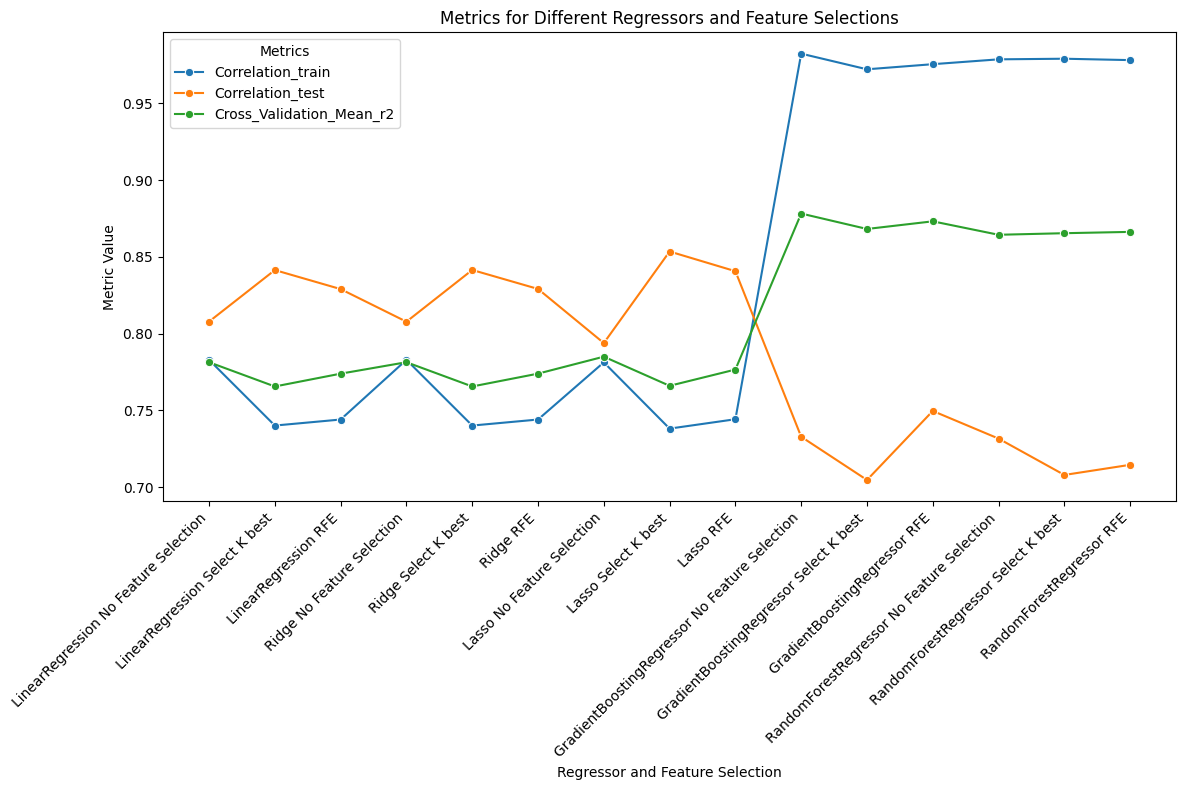

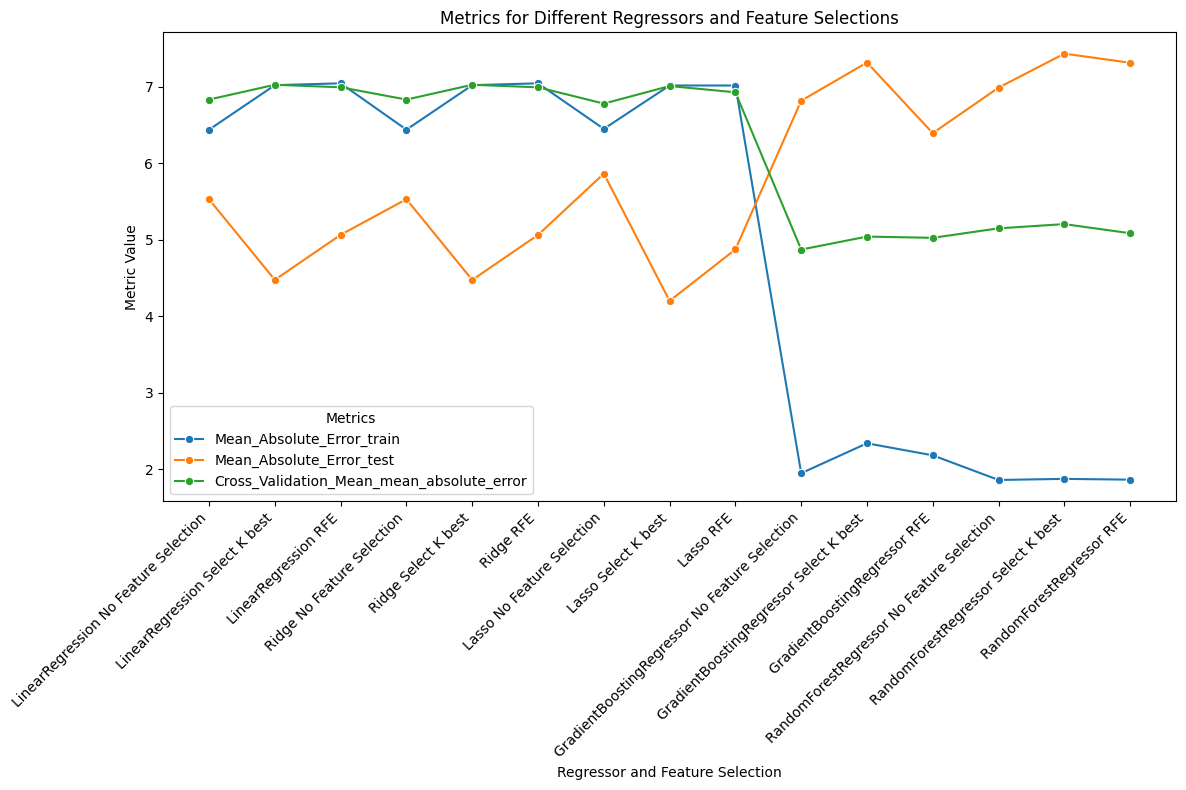

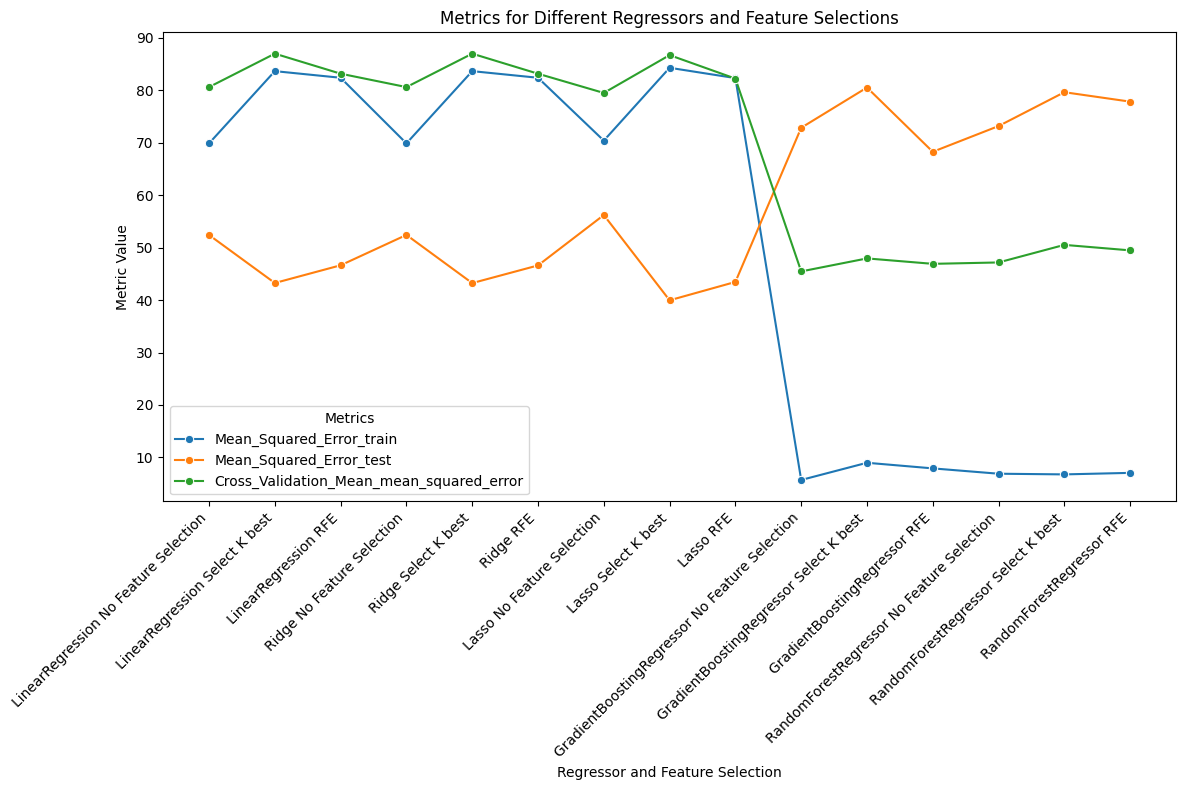

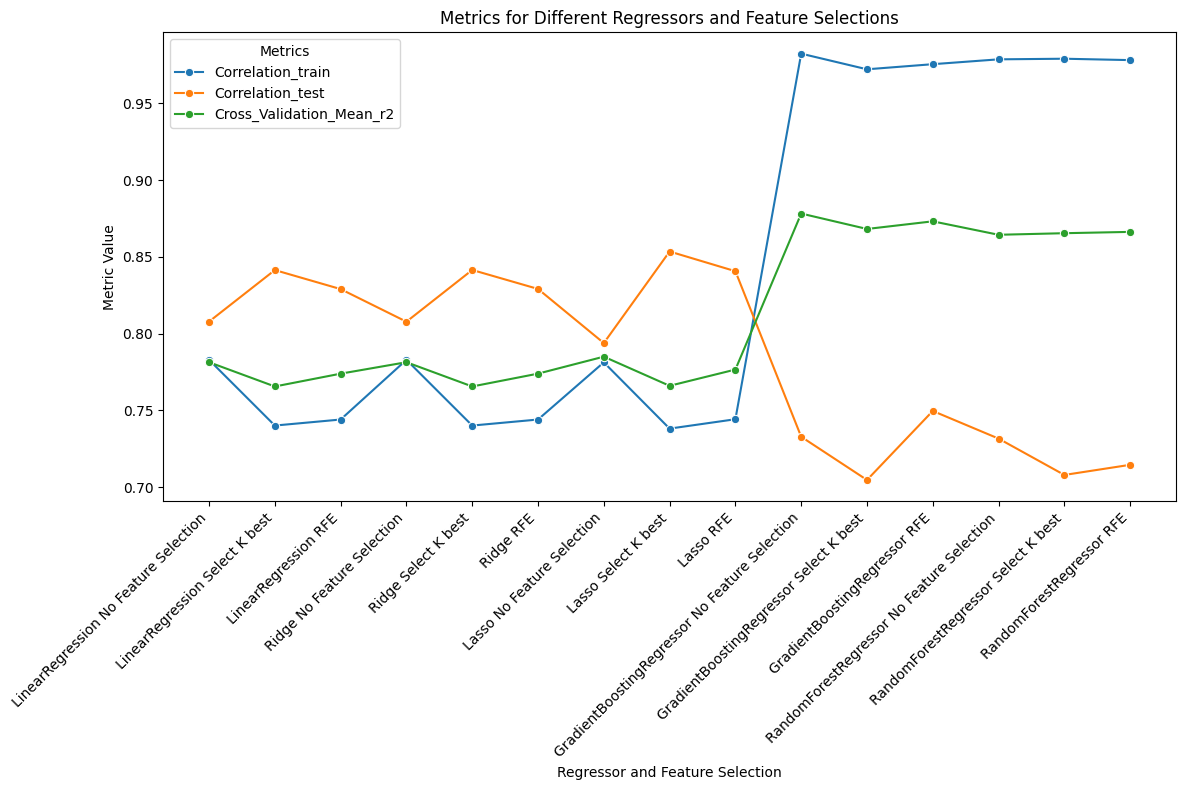

In [87]:
def plot_metrics(df, metrics_to_plot):
    plt.figure(figsize=(12, 8))
    
    for column in metrics_to_plot:
        sns.lineplot(data=df, x='Regressor_Feature_Selection', y=column, marker='o', label=column)
    
    plt.xlabel('Regressor and Feature Selection')
    plt.ylabel('Metric Value')
    plt.title('Metrics for Different Regressors and Feature Selections')
    
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metrics')

    plt.tight_layout()
    plt.show()

plot_metrics(assessment_results, ['Correlation_train',	'Correlation_test', 'Cross_Validation_Mean_r2'])
plot_metrics(assessment_results, ['Mean_Absolute_Error_train',	'Mean_Absolute_Error_test', 'Cross_Validation_Mean_mean_absolute_error'])
plot_metrics(assessment_results, ['Mean_Squared_Error_train',	'Mean_Squared_Error_test', 'Cross_Validation_Mean_mean_squared_error'])
plot_metrics(assessment_results, ['Correlation_train',	'Correlation_test', 'Cross_Validation_Mean_r2'])
